In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 1
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory, get_gpu_device
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = False
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [9]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [10]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
0,0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976,False
1,1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393,False
2,2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691,False
3,3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181,False
4,4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246,False
5697958,5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382,False
5697959,5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200,False
5697960,5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274,False


In [11]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [12]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329
...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182


## Batches of ZTF Data Near Initial Candidate Elements

In [13]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [14]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [15]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,9472,0,b'ZTF18ablreca',582228440915015051,4429,58336.228449,275.623971,-19.732784,0.092245,-0.993751,...,0.063652,-0.994811,0.079366,1.669246,0.033041,6815.410019,0.999454,0.896032,False,False
1,9523,0,b'ZTF18ablrrmm',582228441515010169,4429,58336.228449,274.474165,-20.557661,0.073042,-0.996118,...,0.063652,-0.994811,0.079366,1.669246,0.031681,6534.850780,0.999498,0.823785,False,False
2,9524,0,b'ZTF18ablrrmm',583325941515010039,4533,58337.325949,274.474106,-20.557585,0.073041,-0.996118,...,0.061522,-0.994926,0.079609,1.676021,0.032596,6723.784176,0.999469,0.872104,False,False
3,83268,0,b'ZTF18abkiuvs',583325941515015015,4533,58337.325949,274.254244,-20.690837,0.069398,-0.996485,...,0.061522,-0.994926,0.079609,1.676021,0.033655,6942.119800,0.999434,0.929656,False,False
4,83271,0,b'ZTF18abkiuvs',582228441515015011,4429,58336.228449,274.254253,-20.690856,0.069398,-0.996485,...,0.063652,-0.994811,0.079366,1.669246,0.032988,6804.644809,0.999456,0.893204,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47351,5244546,63,b'ZTF20aanbicp',1139161934315015010,93033,58893.161933,37.471372,19.129852,0.749830,0.657697,...,0.748948,0.654175,0.105506,2.518142,0.033664,6944.105315,0.999433,0.930188,False,False
47352,5381276,63,b'ZTF18abomwia',1142181624015015000,94184,58896.181620,36.733350,20.616292,0.750104,0.653657,...,0.737167,0.667517,0.104914,2.561837,0.019494,4020.896645,0.999810,0.311897,False,False
47353,5381393,63,b'ZTF20aaogfkm',1142181623915015001,94184,58896.181620,39.193902,19.790850,0.729236,0.680236,...,0.737167,0.667517,0.104914,2.561837,0.034247,7064.277329,0.999414,0.962658,False,False
47354,5445787,63,b'ZTF20aapczfl',1145109243715015002,94770,58899.109248,38.029908,20.665282,0.737008,0.669246,...,0.725274,0.680505,0.104353,2.603903,0.019017,3922.518773,0.999819,0.296822,False,False


In [16]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [17]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [18]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [19]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :    47356   (      740)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     105.28
Sqrt(batch_obs):      27.20
Mean t_score   :       4.36


In [21]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830,10,0.008727,0.034905,16.5,4.0
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190,10,0.008727,0.034905,16.5,4.0
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896,10,0.008727,0.034905,16.5,4.0
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206,10,0.008727,0.034905,16.5,4.0
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086,10,0.008727,0.034905,16.5,4.0
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723,10,0.008727,0.034905,16.5,4.0
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016,10,0.008727,0.034905,16.5,4.0
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [22]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [23]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [24]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_rand_unknown_{random_seed:04d}.h5',
                name='model')

In [25]:
model.load()

In [ ]:
raise ValueError

In [26]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :    10.15  :   0.00 :  1442.53 :  7073.12
Mean     :    10.15  :   0.00 :  1442.53 :  7073.12
Median   :     6.78  :   0.00 :  1424.26 :  7200.00
GeoMean  :     7.80  :   0.00 :  1330.56 :  7038.29
Min      :     2.61  :   0.00 :   374.87 :  3577.30
Max      :    46.96  :   0.00 :  2831.63 :  7200.00
Trained for 800 batches over 16 epochs and 4 episodes (elapsed time 28 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



********************************************************************************
Round 1: 800 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200
********************************************************************************

Training episode 4: Epoch   16, Batch    800
effective_learning_rate=2.441e-04, training_time 28 sec.
Train on 3200 samples
Epoch 17/20
3200/3200 [==============================] - 2s 679us/sample - loss: -484462.0856
Epoch 18/20
3200/3200 [==============================] - 1s 269us/sample - loss: -508464.9637
Epoch 19/20
3200/3200 [==============================] - 1s 266us/sample - loss: -535567.2656
Epoch 20/20
3200/3200 [==============================] - 1s 268us/sample - loss: -566513.4950
Adjusted element weight down on 3 candidate elements. Mean weight = 9.53e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1430.52 :  1430.52 :      nan arc seconds
Geom Mean Threshold :   6995.90 :  6995.90 :      nan arc secon

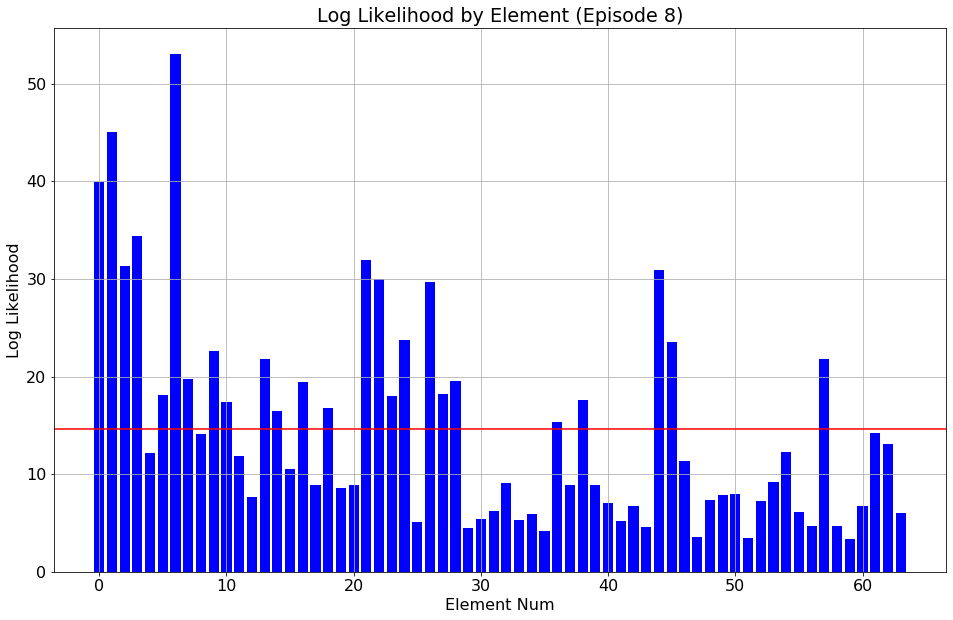

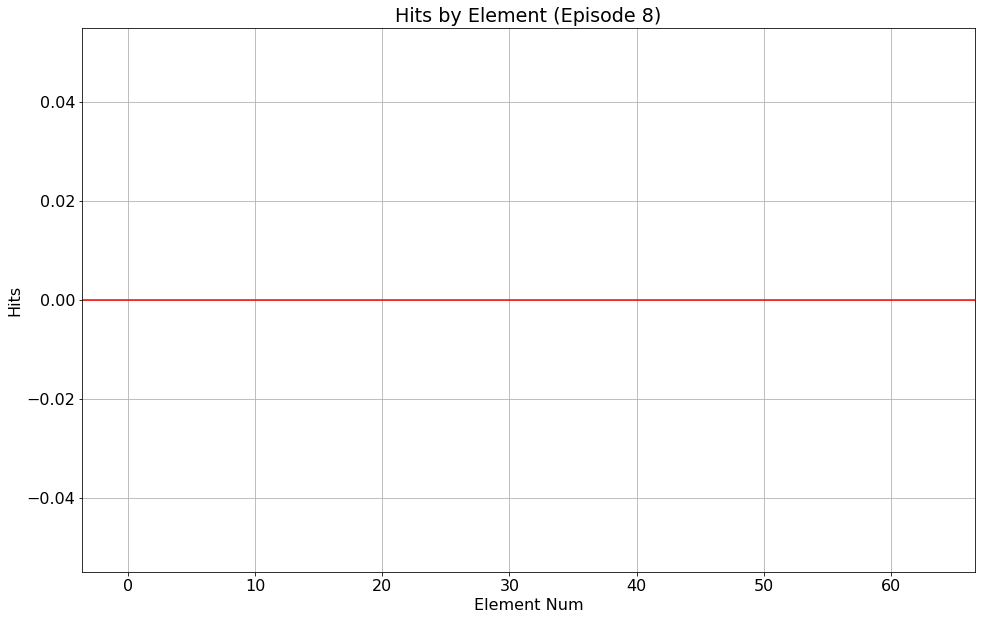

In [27]:
# model.sieve_round(1, 
#                   num_batches=800, 
#                   batches_per_epoch=50, 
#                   epochs_per_episode=4, 
#                   training_mode='mixture', 
#                   learning_rate=2**-12,
#                   min_learning_rate=2**-20,
#                   R_sec_max=3600,
#                   thresh_sec_max=7200)

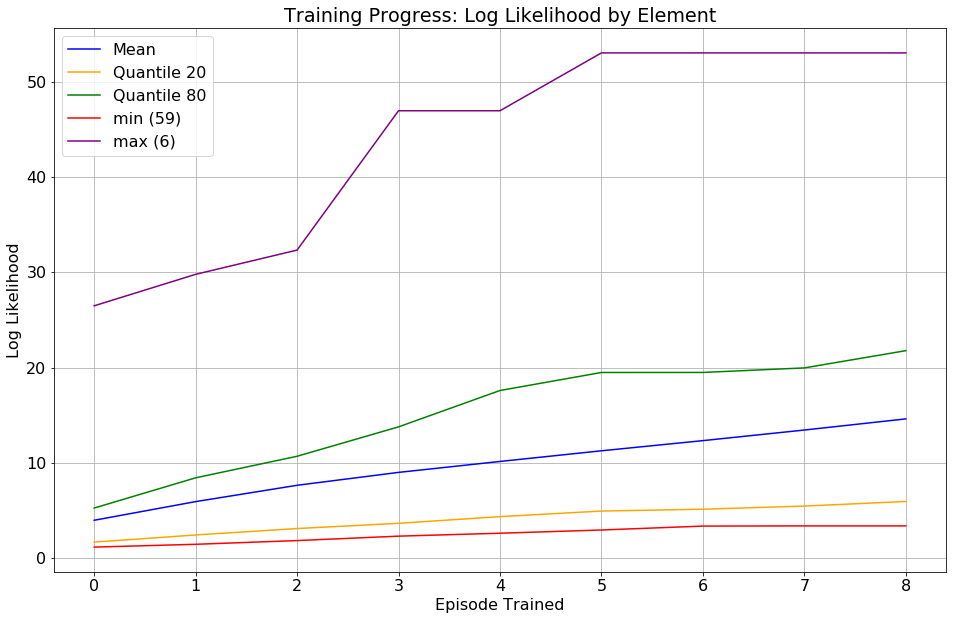

In [28]:
fig, ax = model.plot_hist(att_name='log_like', x_axis='episode')

In [ ]:
self = model

In [ ]:
elts_1 = pd.read_hdf(self.file_path, key='elts')

In [ ]:
episode = 4
hist = self.train_hist_elt
mask = (hist.episode == episode)

# Candidate  elements used to restore training state
elts_2 = hist[mask]

In [ ]:
elts_1.columns

In [ ]:
cols = self.candidates_df().columns
cols

In [ ]:
hist = self.train_hist_elt
mask = (hist.episode == 4)

In [ ]:
elts = hist[cols][mask]
# elts['epoch'] = 

In [ ]:
col = 'epoch'
elts_2[col].values - elts_1[col].values

In [ ]:
elts_2.rename(columns={'num_hits_': 'num_hits__'})

In [ ]:
elts_1[col]

In [ ]:
elts_2[col]

In [29]:
model.revert_training(episode=4)

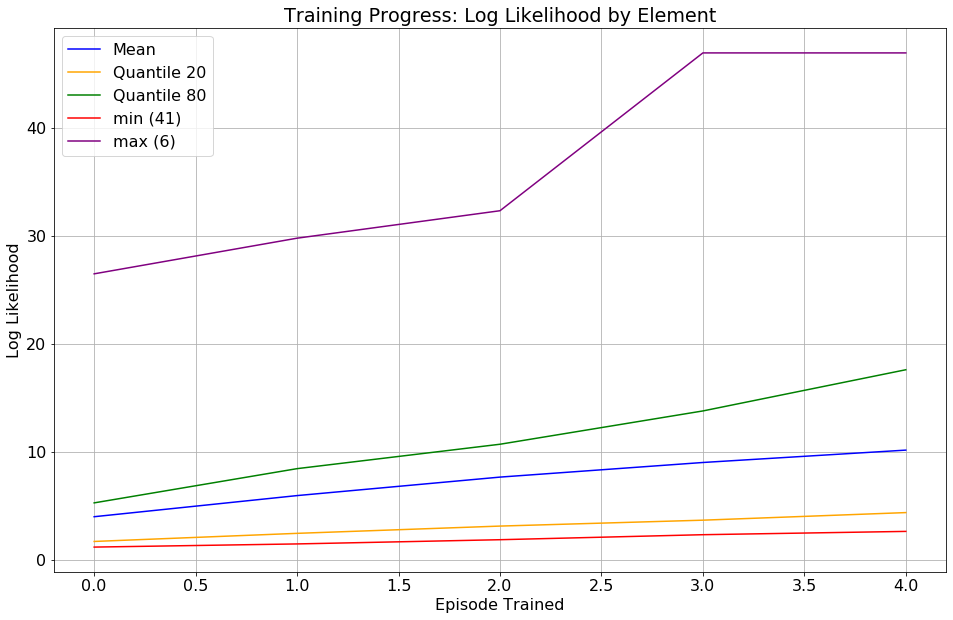

In [30]:
fig, ax = model.plot_hist(att_name='log_like', x_axis='episode')

## Automated Training with Sieve Method

In [ ]:
# model.sieve(nearest_ast=False)

## Review Results Graphically

In [ ]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

In [ ]:
self = model

In [ ]:
hist = self.train_hist_elt

In [ ]:
hist

In [ ]:
episode = 4
mask = (hist.episode == episode)
elts = hist[mask]
elts

In [ ]:
summary = self.train_hist_summary

In [ ]:
summary

In [ ]:
episode = 4
mask = (summary.episode <= episode)

In [ ]:
summary[mask]

In [ ]:
idx = summary.index[summary.epoch == epoch][0]
idx

In [ ]:
summary.episode.loc[idx]